In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
# Explore original dataset
df = pd.read_csv('riga.csv')
df.head()

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon
0,For rent,Purvciems,Dzelzavas 93,1,27.0,3.0,5.0,LT proj.,Brick-Panel,All amenities,250.0,56.955484,24.202139
1,For rent,Ziepniekkalns,Ozolciema 32,2,50.0,7.0,9.0,602.,Panel,All amenities,300.0,56.899798,24.098350
2,For sale,centrs,Ieroču 6,2,33.0,1.0,2.0,P. kara,Wood,Partial amenities,13500.0,56.975092,24.139884
3,For sale,Ķengarags,Maskavas 305,2,50.0,5.0,5.0,LT proj.,Panel,All amenities,34000.0,56.859788,24.308342
4,For rent,Teika,Zemgala gatve 80,3,76.0,3.0,12.0,Jaun.,Masonry,All amenities,490.0,56.977745,24.166042


In [3]:
# We will create a model to predict sale price only for simplicity
df = df[df['op_type'] == 'For sale']
df = df.drop(columns=['op_type', 'street', 'house_type', 'house_seria', 'condition', 'lat', 'lon'])
df.head()

,district,rooms,area,floor,total_floors,price
2,centrs,2,33.0,1.0,2.0,13500.0
3,Ķengarags,2,50.0,5.0,5.0,34000.0
6,Ķengarags,2,37.0,5.0,5.0,31000.0
10,Mangaļi,2,46.0,4.0,5.0,39999.0
11,Jugla,3,58.0,4.0,5.0,50000.0


In [4]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1696 train examples
424 validation examples
530 test examples


In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('price').astype('float64')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [6]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [7]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of areas:', train_features['area'])
print('A batch of targets:', label_batch )

Every feature: ['district', 'rooms', 'area', 'floor', 'total_floors']
A batch of areas: tf.Tensor([24. 88. 53. 53. 32.], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([ 30000. 147000.  41500.  49000.  48900.], shape=(5,), dtype=float64)


In [8]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [9]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [10]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a StringLookup layer which will turn strings into integer indices
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Create a Discretization for our integer indices.
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    # Prepare a Dataset that only yields our feature.
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices.
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices. The lambda function captures the
    # layer so we can use them, or include them in the functional model later.
    return lambda feature: encoder(index(feature))

In [11]:
all_inputs = []
encoded_features = []

# Numeric features

for header in ['rooms', 'floor', 'total_floors', 'area']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [12]:
# Categorical features    

for header in ['district']:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [13]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, kernel_initializer='he_uniform', activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16, kernel_initializer='he_uniform', activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation="relu")(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [14]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
district (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
rooms (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
floor (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
total_floors (InputLayer)       [(None, 1)]          0                                            
_______________________________________________________________________________________

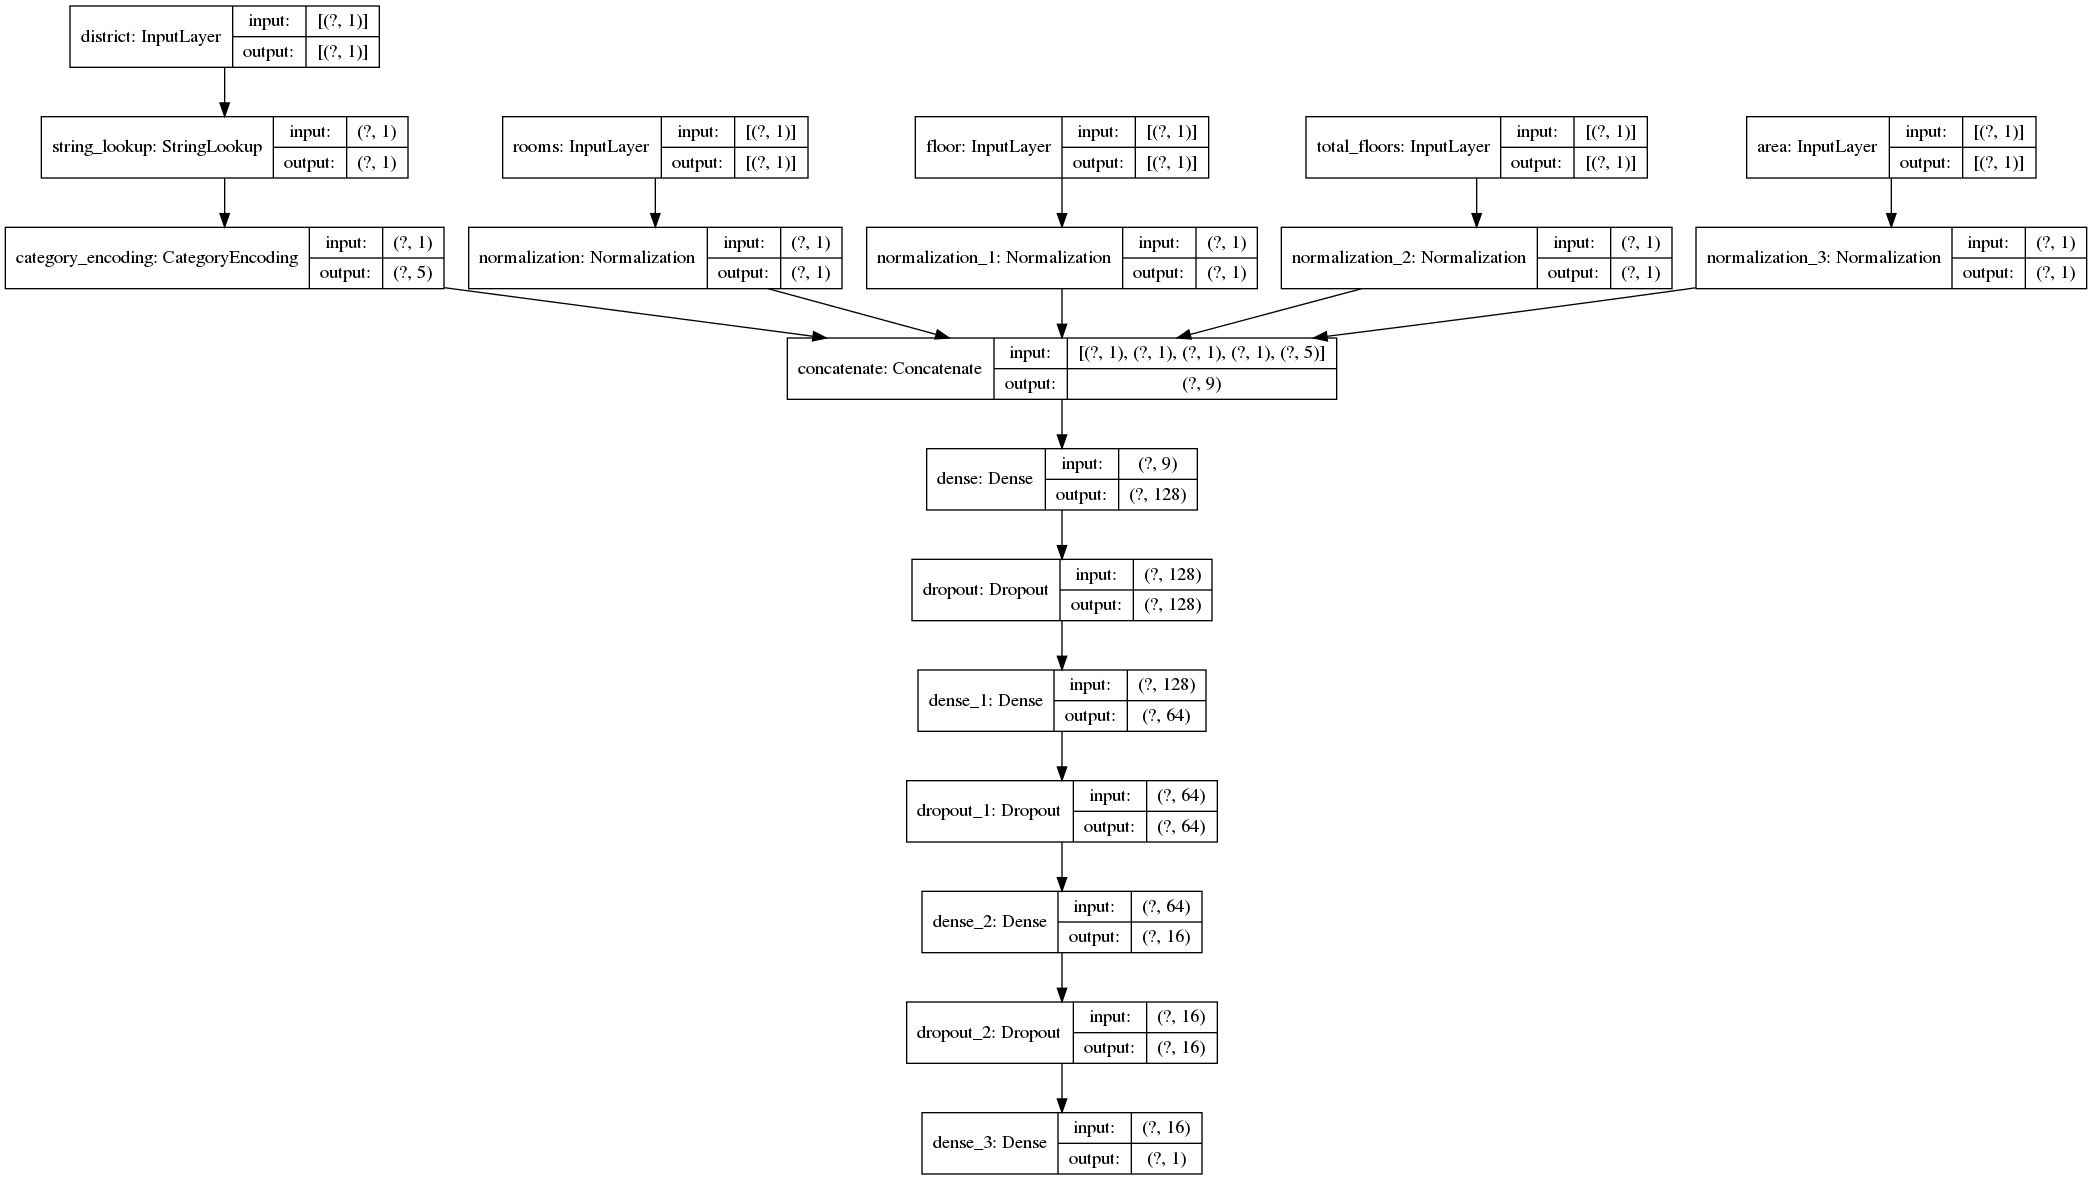

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="TB")

In [16]:
model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
7/7 [==============================] - 0s 28ms/step - loss: 91647.3516 - mean_absolute_error: 91647.3516 - val_loss: 91881.1719 - val_mean_absolute_error: 91881.1719
Epoch 2/10
7/7 [==============================] - 0s 6ms/step - loss: 91646.0391 - mean_absolute_error: 91646.0391 - val_loss: 91879.2812 - val_mean_absolute_error: 91879.2812
Epoch 3/10
7/7 [==============================] - 0s 6ms/step - loss: 91644.0312 - mean_absolute_error: 91644.0312 - val_loss: 91876.8672 - val_mean_absolute_error: 91876.8672
Epoch 4/10
7/7 [==============================] - 0s 6ms/step - loss: 91641.3203 - mean_absolute_error: 91641.3203 - val_loss: 91873.7188 - val_mean_absolute_error: 91873.7188
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 91637.9219 - mean_absolute_error: 91637.9219 - val_loss: 91869.6406 - val_mean_absolute_error: 91869.6406
Epoch 6/10
7/7 [==============================] - 0s 6ms/step - loss: 91633.1094 - mean_absolute_error: 91633.1094 - va

In [17]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

3/3 [==============================] - 0s 2ms/step - loss: 91481.5625 - mean_absolute_error: 91481.5625
Accuracy 91481.5625


In [19]:
model.save('./model')
reloaded_model = tf.keras.models.load_model('./model')

INFO:tensorflow:Assets written to: ./model/assets


In [21]:
sample = {
    'district': 'Centrs',
    'rooms': 5,
    'floor': 1,
    'total_floors': 2,
    'area': 1,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)

print(predictions)

[[108.25255]]
